In [1]:
%matplotlib widget

In [1]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../templates/slow_extraction_tutorial")
import plot_helpers

In [2]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('../LATTICE/Prova3.seq') # Starting from electrostatic septum
mad.beam()
mad.use('CNAO3S0')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.12.01 11:49:25      +
  ++++++++++++++++++++++++++++++++++++++++++++
assign, echo=output.out;





TITLE, "CNAO SYNC";







S0_001A_MBS: SBEND, L= 1.6772, 

E1 := 0.19634954085, E2 := 0.19634954085, ANGLE = 0.3926990817, 

K0 := 0.3926990817/1.6772, K1 := 0, K2 := 0, 

HGAP = 0.036, FINT:=FINTVAL;

S0_001B_TSP: MARKER;

S0_002A_DRI: DRIFT, L= 0.2101525103;

S0_003A_FLS: MARKER;

S0_004A_DRI: DRIFT, L= 0.109;

S0_005A_QUS: QUADRUPOLE, L= 0.36, 

K1 := KF;



S0_006A_BS1: MARKER;

S0_007A_DRI: DRIFT, L= 0.101;

S0_008A_FLS: MARKER;

S0_009A_PUH: HMONITOR, L= 0.3;

S0_010A_FLS: MARKER;

S0_011A_DRI: DRIFT, L= 0.061;

S0_012A_SSM: MARKER;

S0_013A_DRI: DRIFT, L= 0.056;

S0_014A_DIA: MARKER;

S0_015A_DRI: DRIFT, L= 0.033;

S0_016A_MSP: DRIFT, L= 0.65;

S0_017A_DRI: DRIFT, L= 0.9

In [3]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.CNAO3S0,
                                  deferred_expressions=True)

Converting sequence "cnao3s0":   0%|          | 0/392 [00:00<?, ?it/s]

In [4]:
# Choose the appropriate bend model
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=15)

In [5]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6) # eV

### Match

In [6]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 0.7412        
Matching: model call n. 8               
Optimize - end penalty:  7.8389e-05


In [7]:
line.build_tracker()

The line already has an associated tracker


In [8]:
# Define number of turns and number of particles for the simulation
num_turns = 10000
num_particles = 100

x_distribution = np.linspace(0, 4.8, 10)
delta_distribution = np.zeros(10)

# Build Particles
particles = line.build_particles(
    x_norm = np.tile(x_distribution, 10),
    px_norm = np.zeros(num_particles),
    y_norm = np.random.normal(size=num_particles),
    py_norm = np.random.normal(size=num_particles),
    delta = np.repeat(delta_distribution, 10),
    zeta= np.zeros(num_particles),
    method='4d',
    nemitt_x=0.52e-6, nemitt_y=1e-8
)

p0 = particles.copy()

In [9]:
# Track logging turn-by-turn data
line.track(particles, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True)
rec = line.record_last_track

Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, '$x$ [m]')

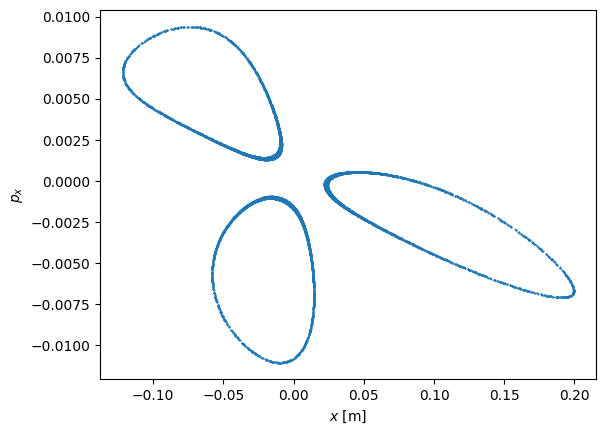

In [11]:
# Plot turn by turn data (physical phase space for the 100th generated particle)
plt.figure()
plt.plot(rec.x[99, :], rec.px[99, :], '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')

Text(0, 0.5, '$x$ [m]')

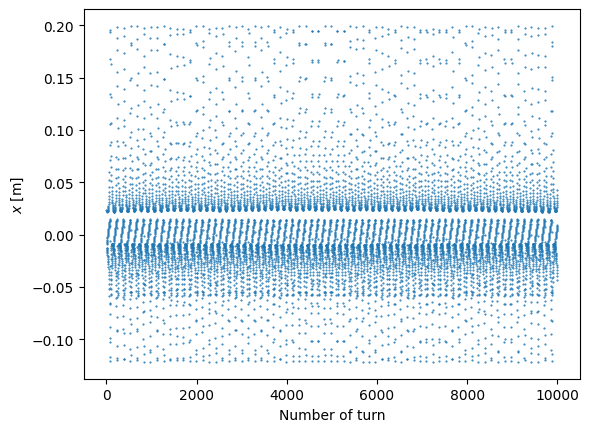

In [12]:
turns = np.arange(1, num_turns+1, 1, dtype=int)

# Plot for the 100th particle, for all turns
plt.figure()
plt.plot(turns, rec.x[99, :], '.', markersize=1, color='C0')
plt.xlabel("Number of turn")
plt.ylabel(r"$x$ [m]")

In [13]:
sampling_rate = 1 # Hz
T = 1.0 / sampling_rate  # Sample spacing (time interval)
N = num_turns # Number of sample points
t = np.linspace(0.0, N*T, N, endpoint=False)  # Time array

signal = []
fft_signal = []

for i in range(0, num_particles):
    signal.append(rec.x[i, :])
    # Compute the Fast Fourier Transform (FFT)
    fft_signal.append(np.fft.fft(signal[i]))

# Compute the magnitude (absolute value) of the FFT
fft_magnitude = 2.0 / N * np.abs(fft_signal)

# Compute the frequency axis
frequencies = np.fft.fftfreq(N, T)[:N // 2]

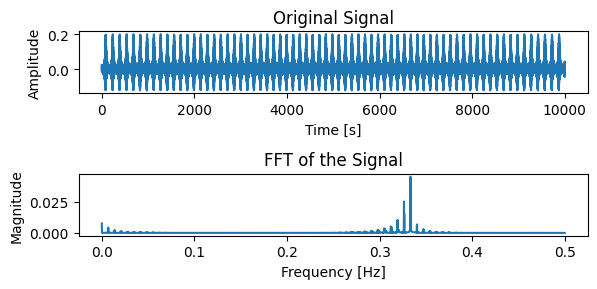

In [14]:
# Select Number of particle
part_number = 99

# Plot the original signal and its FFT
plt.close("all")
plt.figure(figsize=(6, 3))

# Plot the signal
plt.subplot(2, 1, 1)
plt.plot(t, signal[part_number])
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the FFT
plt.subplot(2, 1, 2)
plt.plot(frequencies, fft_magnitude[part_number, :][:N // 2])
plt.title('FFT of the Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()

plt.show()

In [15]:
particles_tunes = []

for i in range(0, num_particles):
    # Get the index of the maximum fft_mangitude (excluding the first) and get the corespnding frequency.
    # 2 minus the frequency value (fractional tune) is equal to the tune of each particle
    particles_tunes.append(2-frequencies[np.argmax(fft_magnitude[i, :][1:N  // 2])])

# Print the list of the calulated particle tunes
print(list(map(float, particles_tunes)))

[1.6661, 1.6663000000000001, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6668, 1.668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.5201, 1.6663000000000001, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6679, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6667, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.5201, 1.6663000000000001, 1.668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.668, 1.6669, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6668, 1.6669, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6661, 1.6663000000000001, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668, 1.6668]


In [16]:
# Maximum and minimum calculated particle tunes
max(particles_tunes), min(particles_tunes)

(np.float64(1.668), np.float64(1.5201))

In [17]:
# Range of particle tunes
max(particles_tunes) - min(particles_tunes)

np.float64(0.14789999999999992)

The 1.5201 seems like an extremely low value so below I calculate the indeces and the corresponding x coordinate.

In [18]:
indices = [i for i, val in enumerate(particles_tunes) if val == 1.5201]
indices ,particles.x[indices]

([20, 60], array([-5.22711155e-07, -5.66403072e-07]))

In [19]:
# Compute normalized coordinates
tw = line.twiss(method='4d')
nc = tw.get_normalized_coordinates(rec)

# Horizontal tune and chromaticity
tw.qx, tw.dqx

(np.float64(1.6660000099585295), np.float64(-2.999921769988312))

Text(0, 0.5, 'A')

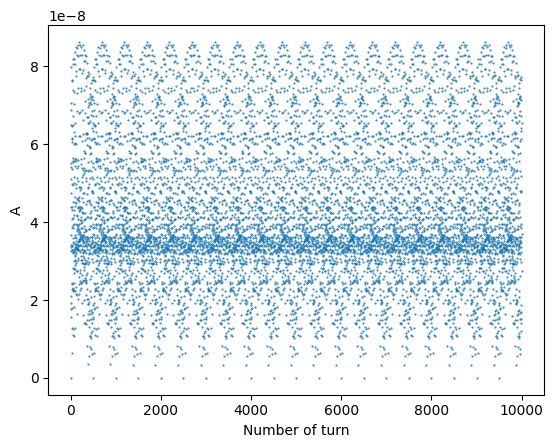

In [20]:
# Plot normalised amplitude against the number of turns
norm_amplitude = np.sqrt(nc.x_norm**2 + nc.px_norm**2)
plt.figure()
plt.plot(turns, norm_amplitude[0,:], '.', markersize=1)
plt.xlabel("Number of turn")
plt.ylabel("A")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


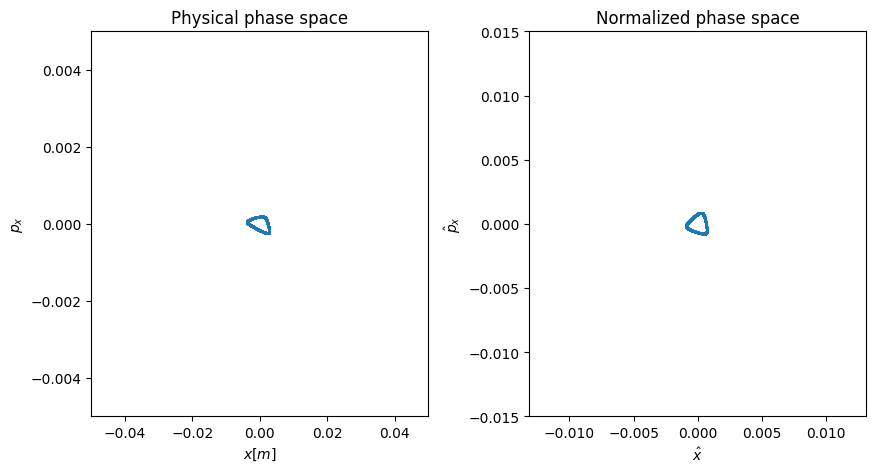

In [21]:
# Plot physical and normalised phase space side by side
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot

ax_geom.plot(rec.x[1, :], rec.px[1, :], '.', markersize=1, color='C0')
ax_norm.plot(nc.x_norm[1, :], nc.px_norm[1, :],
           '.', markersize=1, color='C0')

In [22]:
# Resonance Sextupole Preview
line["s8_028a_sxr"]

View of Sextupole(k2=-3.3, k2s=0, length=0.26, _order=np.int64(5), inv_factorial_order=0.00833, knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.uint64(0), edge_exit_active=np.uint64(0), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _internal_record_id=RecordIdentifier(buffer_id=np.int64(0), offset=np.int64(0)))

Let's calculate the particle tunes with 2 different methods and compare them below

In [23]:
(particles.delta * tw.dqx + tw.qx) - particles_tunes

LinkedArrayCpu([-9.99900415e-05, -2.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -9.99900415e-05, -2.99990041e-04,
                -7.99990041e-04, -1.99999004e-03, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04,  1.45900010e-01,
                -2.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -9.99900415e-05, -2.99990041e-04, -1.89999004e-03,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e-04,
                -7.99990041e-04, -9.99900415e-05, -2.99990041e-04,
                -7.99990041e-04, -7.99990041e-04, -7.99990041e

In [24]:
# Particle frequencies 
tw.slip_factor * particles.delta / tw.T_rev0 + (1 / tw.T_rev0) 

LinkedArrayCpu([1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318348.95873667, 1318348.95873667, 1318348.95873667,
                1318